In [1]:
# Import Necessary Libraries
import os

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from utils.dataimporter import SoliDataImporter
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1. Data Loading

In [2]:
# Device type
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

%load_ext autoreload
%autoreload 2

cuda


In [3]:
# Data path
data_directory = "/content/drive/MyDrive/google_soli/dataset/dsp"

# Create Soli Dataloading class instance
soli_dataimporter = SoliDataImporter(data_directory)

# stacked_frames: Number of frames x 1024 x Number of channels
# labels: Number of frames
stacked_radar_data, labels = soli_dataimporter.load_deep_soli_data()

In [4]:
# Convert data into 32x32 images
stacked_images, labels = soli_dataimporter.convert_to_images(stacked_radar_data, labels)

print("Combined data shape:", stacked_images.shape)
print("Combined labels shape:", labels.shape)

Combined data shape: (169457, 32, 32, 4)
Combined labels shape: (169457,)


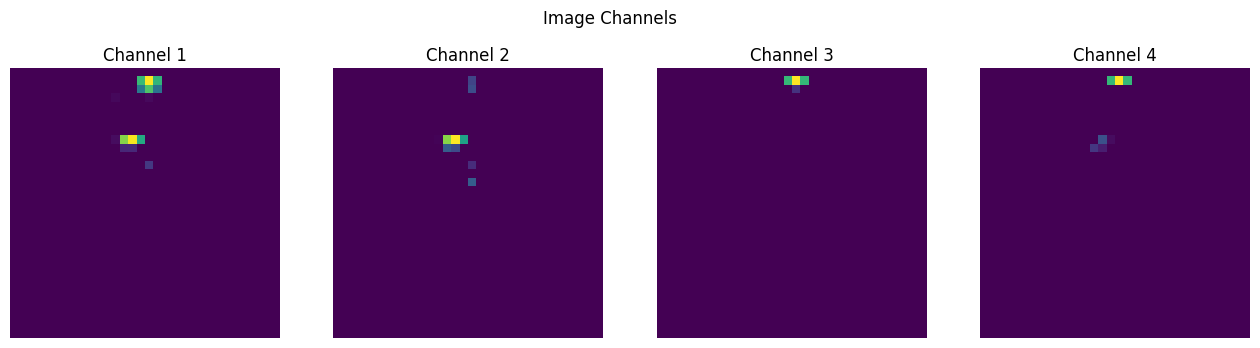

In [5]:
test_image = stacked_images[200]

# Plot each of the 4 channels separately for a test image
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

for i in range(4):
    axs[i].imshow(test_image[:, :, i])
    axs[i].set_title(f'Channel {i+1}')
    axs[i].axis('off')

plt.suptitle('Image Channels')
plt.show()

In [6]:
import utils.transforms as transforms

# Computer mean and standard deviation per channel and apply normalize transform
mean, std = transforms.compute_image_mean_and_std(stacked_images)
normalize_transform = transforms.NormalizeTransform(mean, std)

compose_transform = transforms.CombineTransforms([
    normalize_transform
])

stacked_images = compose_transform(stacked_images)

In [8]:
# Split dataset into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(stacked_images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [9]:
# Convert numpy arrays to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Change of shape from NxHxWxC to NxCxHxW
X_train_tensor = X_train_tensor.permute(0, 3, 1, 2)
X_val_tensor = X_val_tensor.permute(0, 3, 1, 2)
X_test_tensor = X_test_tensor.permute(0, 3, 1, 2)

print(f'Train data shape: {X_train_tensor.shape}, Train labels shape: {y_train_tensor.shape}')
print(f'Val data shape: {X_val_tensor.shape}, Val labels shape: {y_val_tensor.shape}')
print(f'Test data shape: {X_test_tensor.shape}, Test labels shape: {y_test_tensor.shape}')

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Train data shape: torch.Size([118619, 4, 32, 32]), Train labels shape: torch.Size([118619])
Val data shape: torch.Size([25419, 4, 32, 32]), Val labels shape: torch.Size([25419])
Test data shape: torch.Size([25419, 4, 32, 32]), Test labels shape: torch.Size([25419])


2. Training

In [10]:
from utils.model import SoliCNNTaskB1

# Create the model
num_classes = 11
model = SoliCNNTaskB1(num_classes)

The architecture can be seen below. Depth-wise convolution is used to replace average pool (not shown in the below image). 

![Architecture](images/Architecture_B.png)

In [11]:
from utils.model_helper_functions import ModelHelper

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Create a helper instance. Model helper contains functions for training and evaluating the model.
helper = ModelHelper(model, device=device)

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = helper.train_model(train_loader, val_loader, num_epochs=40, learning_rate=0.0005, mult_learning_rate=0.3)

Learning rate:  0.0005
Epoch [1/40], Train Loss: 1.4501, Train Accuracy: 47.40%, Validation Loss: 1.2817, Validation Accuracy: 53.84%
Epoch [2/40], Train Loss: 1.2206, Train Accuracy: 56.69%, Validation Loss: 1.1772, Validation Accuracy: 58.40%
Epoch [3/40], Train Loss: 1.1210, Train Accuracy: 60.25%, Validation Loss: 1.0937, Validation Accuracy: 61.09%
Epoch [4/40], Train Loss: 1.0395, Train Accuracy: 62.99%, Validation Loss: 1.0314, Validation Accuracy: 63.37%
Epoch [5/40], Train Loss: 0.9704, Train Accuracy: 65.26%, Validation Loss: 0.9533, Validation Accuracy: 65.71%
Epoch [6/40], Train Loss: 0.9216, Train Accuracy: 67.05%, Validation Loss: 0.9140, Validation Accuracy: 67.23%
Epoch [7/40], Train Loss: 0.8853, Train Accuracy: 68.34%, Validation Loss: 0.8835, Validation Accuracy: 68.03%
Epoch [8/40], Train Loss: 0.8567, Train Accuracy: 69.38%, Validation Loss: 0.8509, Validation Accuracy: 69.77%
Epoch [9/40], Train Loss: 0.8339, Train Accuracy: 70.13%, Validation Loss: 0.8449, Valida

In [12]:
# Save the model
torch.save(model, "/content/drive/MyDrive/google_soli/models/F_model_taskB1.pth")

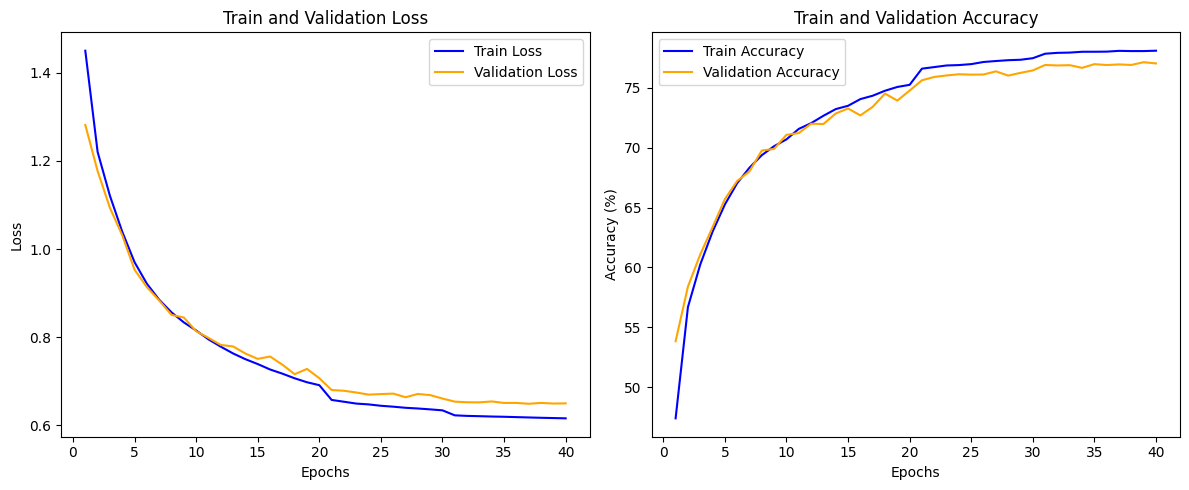

In [15]:
# Plot the accuracies and losses obtained during training
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', color='blue')
    plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
    plt.title('Train and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='orange')
    plt.title('Train and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

In [16]:
# Find total number and size of the parameters
total_params = 0
total_size = 0
print("Parameters per layer:")
for name, param in model.named_parameters():
    if param.requires_grad:
        layer_params = param.numel()
        layer_size_bytes = layer_params * param.element_size()
        total_params += layer_params
        total_size += layer_size_bytes
        print(f"{name}: {layer_params} parameters, {layer_size_bytes} bytes")

print(f'Total number of parameters: {total_params}')
print(f'Total size of parameters: {total_size} bytes')
total_size_kb = total_size / (1024)
print(f'Total size of parameters: {total_size_kb:.2f} KB')

Parameters per layer:
conv1.weight: 288 parameters, 1152 bytes
conv1.bias: 8 parameters, 32 bytes
conv2.weight: 1152 parameters, 4608 bytes
conv2.bias: 16 parameters, 64 bytes
conv3.weight: 2304 parameters, 9216 bytes
conv3.bias: 16 parameters, 64 bytes
fc1.weight: 4096 parameters, 16384 bytes
fc1.bias: 16 parameters, 64 bytes
fc2.weight: 176 parameters, 704 bytes
fc2.bias: 11 parameters, 44 bytes
Total number of parameters: 8083
Total size of parameters: 32332 bytes
Total size of parameters: 31.57 KB


3. Results

Validation Accuracy: 77.04%


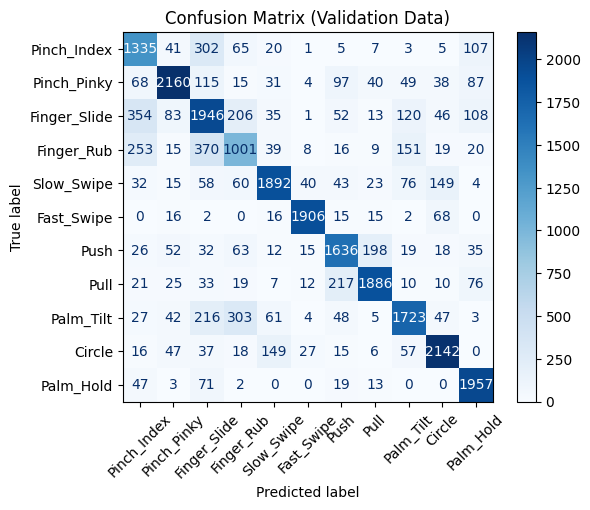

              precision    recall  f1-score   support

 Pinch_Index       0.61      0.71      0.66      1891
 Pinch_Pinky       0.86      0.80      0.83      2704
Finger_Slide       0.61      0.66      0.63      2964
  Finger_Rub       0.57      0.53      0.55      1901
  Slow_Swipe       0.84      0.79      0.81      2392
  Fast_Swipe       0.94      0.93      0.94      2040
        Push       0.76      0.78      0.77      2106
        Pull       0.85      0.81      0.83      2316
   Palm_Tilt       0.78      0.70      0.73      2479
      Circle       0.84      0.85      0.85      2514
   Palm_Hold       0.82      0.93      0.87      2112

    accuracy                           0.77     25419
   macro avg       0.77      0.77      0.77     25419
weighted avg       0.77      0.77      0.77     25419



In [20]:
# Class List
class_list = ["Pinch_Index", "Pinch_Pinky", "Finger_Slide", "Finger_Rub", "Slow_Swipe", "Fast_Swipe", "Push", "Pull", "Palm_Tilt", "Circle", "Palm_Hold"]

# Evaluate the model on validation data and get predictions
accuracy_val, loss_val, y_val_true, y_val_pred = helper.evaluate_model(model, val_loader, device)

# create confusion matrix
cm_val = confusion_matrix(y_val_true, y_val_pred)

# Print the accuracy on validation dataset
print(f'Validation Accuracy: {accuracy_val:.2f}%')

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=class_list)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Validation Data)')
plt.xticks(rotation=45)
plt.show()

print(classification_report(y_val_true, y_val_pred, target_names=class_list))

Test Accuracy: 77.12%


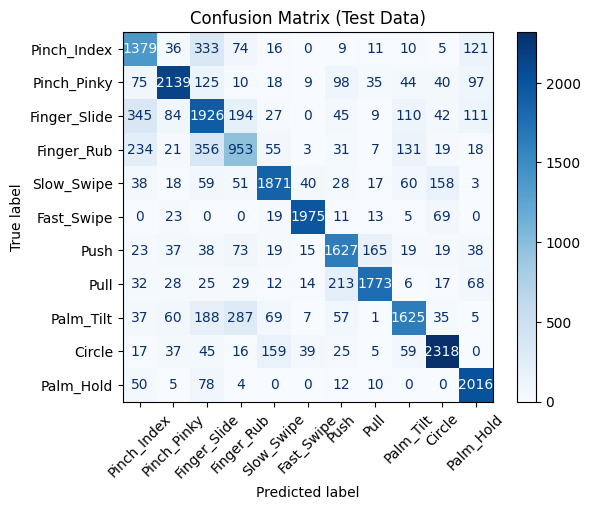

              precision    recall  f1-score   support

 Pinch_Index       0.62      0.69      0.65      1994
 Pinch_Pinky       0.86      0.80      0.83      2690
Finger_Slide       0.61      0.67      0.64      2893
  Finger_Rub       0.56      0.52      0.54      1828
  Slow_Swipe       0.83      0.80      0.81      2343
  Fast_Swipe       0.94      0.93      0.94      2115
        Push       0.75      0.78      0.77      2073
        Pull       0.87      0.80      0.83      2217
   Palm_Tilt       0.79      0.69      0.73      2371
      Circle       0.85      0.85      0.85      2720
   Palm_Hold       0.81      0.93      0.87      2175

    accuracy                           0.77     25419
   macro avg       0.77      0.77      0.77     25419
weighted avg       0.77      0.77      0.77     25419



In [21]:
# Evaluate the model on test data and get predictions
accuracy_test, loss_test, y_test_true, y_test_pred = helper.evaluate_model(model, test_loader, device)

# create confusion matrix
cm_test = confusion_matrix(y_test_true, y_test_pred)

# Print the accuracy on test dataset
print(f'Test Accuracy: {accuracy_test:.2f}%')

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=class_list)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Test Data)')
plt.xticks(rotation=45)
plt.show()

print(classification_report(y_test_true, y_test_pred, target_names=class_list))